In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')

In [3]:
# reduce your memory by conversion
# convert it to the low memory to fit the RAM
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
#merge both the transaction and identity by left
train=pd.merge(train_transaction,train_identity,how="left",on="TransactionID")
test=pd.merge(test_transaction,test_identity,how="left",on="TransactionID")

In [5]:
#now we should reduce the memory to free the RAM or else we cant fit the model
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 168.90 Mb (64.1% reduction)


In [6]:
# delete the 4 variables in order to reduce the memory issue
del train_identity
del test_identity
del train_transaction
del test_transaction

In [7]:
#Try to explore  all the columns in your dataframe
train.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [8]:
#Show categorical variables
train[train.select_dtypes(include=['object']).columns]

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,...,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,W,visa,debit,NaN,NaN,T,T,T,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,W,mastercard,debit,gmail.com,NaN,T,F,F,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,W,mastercard,debit,gmail.com,NaN,T,F,F,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,W,mastercard,debit,aol.com,NaN,T,T,T,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Lets first try converting all the categorical data to numeric
#Convdf = pd.DataFrame()
#for column in train.select_dtypes(include=['object']).columns:
#    dummy_df = pd.get_dummies(train[column])
#    Convdf = pd.concat([Convdf,dummy_df],axis=1)

In [ ]:
#Convdf.shape

In [9]:
train.shape

(590540, 434)

Converting all categorical features to dummies gives us 434 more features. Lets us use the LabelEncoder().

In [10]:
from sklearn import preprocessing
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [11]:
# Lets try to check Categorical features
for column in train.columns:
    if train[column].dtypes == 'object' :
        unique_catg = len(train[column].unique())
        print("Feature '{column}' has {unique_catg} categories".format(column=column, unique_catg=unique_catg))

Feature 'ProductCD' has 5 categories
Feature 'card4' has 5 categories
Feature 'card6' has 5 categories
Feature 'P_emaildomain' has 60 categories
Feature 'R_emaildomain' has 61 categories
Feature 'M1' has 3 categories
Feature 'M2' has 3 categories
Feature 'M3' has 3 categories
Feature 'M4' has 4 categories
Feature 'M5' has 3 categories
Feature 'M6' has 3 categories
Feature 'M7' has 3 categories
Feature 'M8' has 3 categories
Feature 'M9' has 3 categories
Feature 'id_12' has 3 categories
Feature 'id_15' has 4 categories
Feature 'id_16' has 3 categories
Feature 'id_23' has 4 categories
Feature 'id_27' has 3 categories
Feature 'id_28' has 3 categories
Feature 'id_29' has 3 categories
Feature 'id_30' has 76 categories
Feature 'id_31' has 131 categories
Feature 'id_33' has 261 categories
Feature 'id_34' has 5 categories
Feature 'id_35' has 3 categories
Feature 'id_36' has 3 categories
Feature 'id_37' has 3 categories
Feature 'id_38' has 3 categories
Feature 'DeviceType' has 3 categories
Featu

Plotting Fraud vs Genuine transaction


0    9.6501
1    0.3499
Name: isFraud, dtype: float64

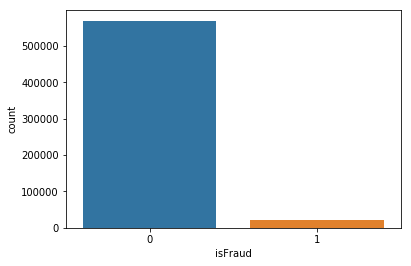

In [12]:
# Visualize isFraud percentage
sns.countplot(train['isFraud'])
print("Plotting Fraud vs Genuine transaction")
train['isFraud'].value_counts(normalize=True) * 10

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

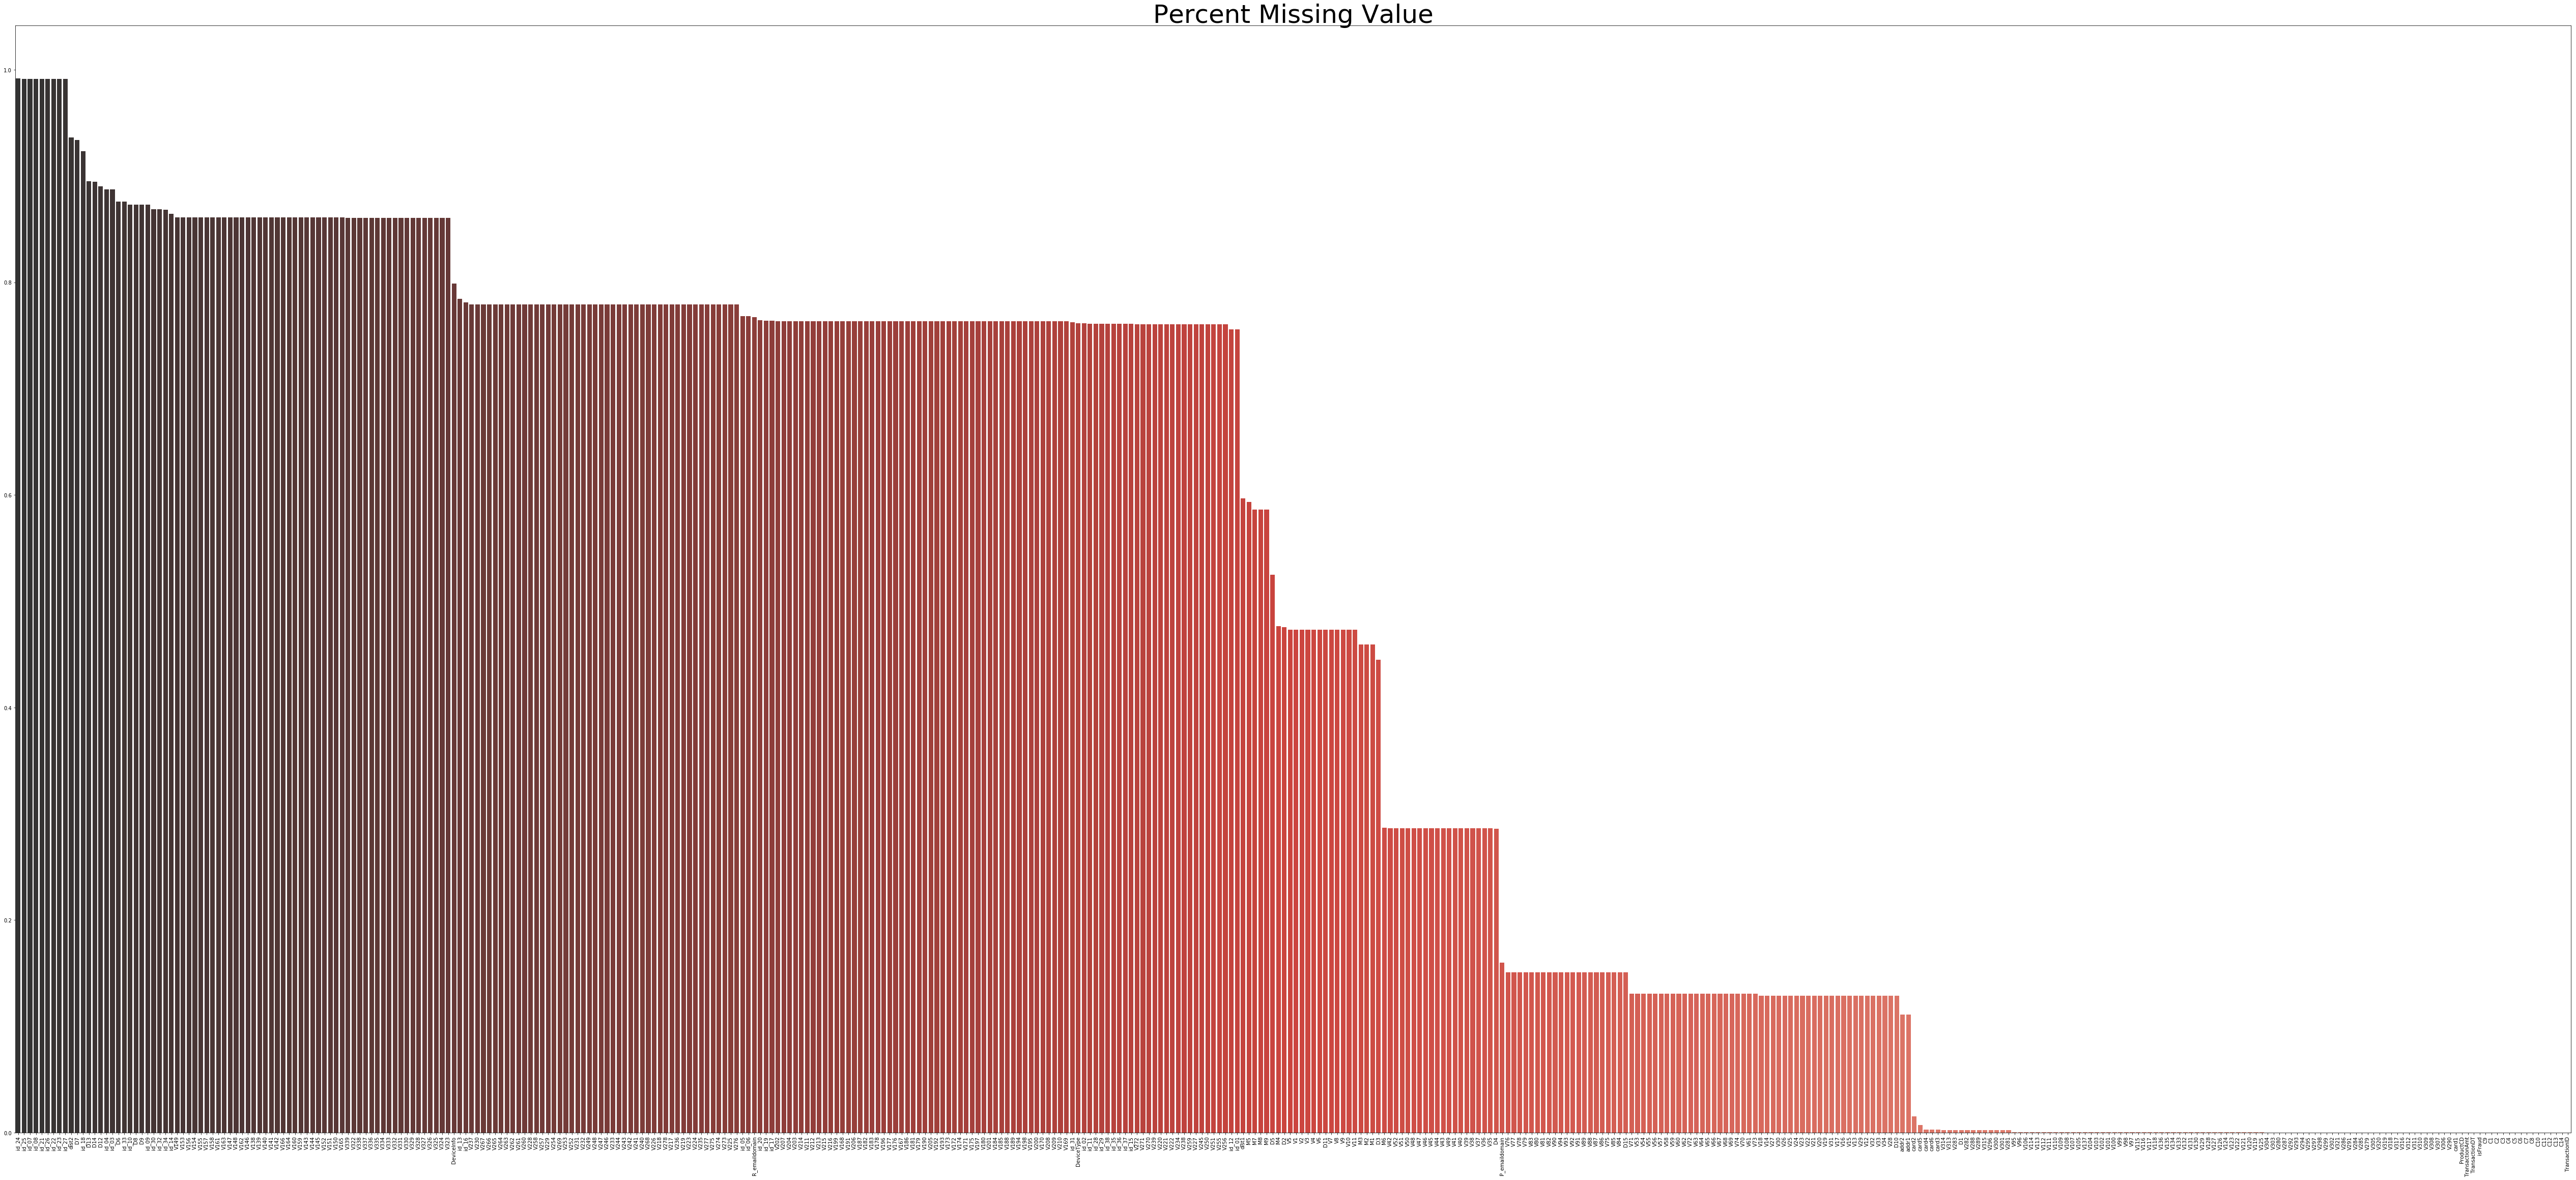

In [13]:
# Lets now try to visualise the NaN values per feature
import matplotlib.pyplot as plt
plt.figure(figsize=(90,40))
sns.barplot(y=train.isnull().sum().sort_values(ascending=False)/len(train),
            x=train.isnull().sum().sort_values(ascending=False).index,
            palette="Reds_d")
plt.title("Percent Missing Value",size=50)
plt.xticks(rotation=90)

In [14]:
# Above plot shows that there are few features for which NA is value is very high. Lets try to remove 
# features having NA percentage more than 80.

na_percent = train.isnull().sum()/train.shape[0]*100
cols_to_drop = np.array(na_percent[na_percent > 80].index)
cols_to_drop

array(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138',
       'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146',
       'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154',
       'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162',
       'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325',
       'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333',
       'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_03', 'id_04',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21',
       'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30',
       'id_32', 'id_33', 'id_34'], dtype=object)

In [15]:
# Drop Columns (cols_to_drop) from train and test
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop,axis=1)

In [16]:
print(train.shape)
print(test.shape)

(590540, 360)
(141907, 359)


# Lets try to plot features

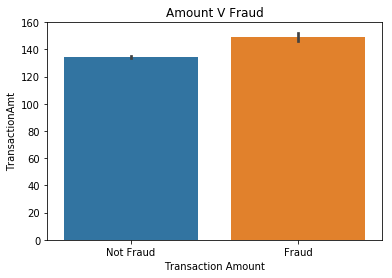

In [17]:
# Amount vs Fraud

amnt = sns.barplot(x = train['isFraud'], y = train['TransactionAmt'], data = train)
plt.title("Amount V Fraud")
amnt.set_xticklabels(['Not Fraud','Fraud'])
amnt.set(xlabel='Transaction Amount')
amnt

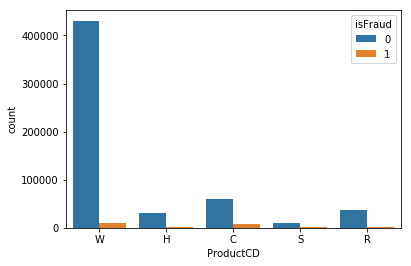

In [18]:
#ProductCD V Fraud count¶

sns.countplot(train['ProductCD'], hue='isFraud', data=train)

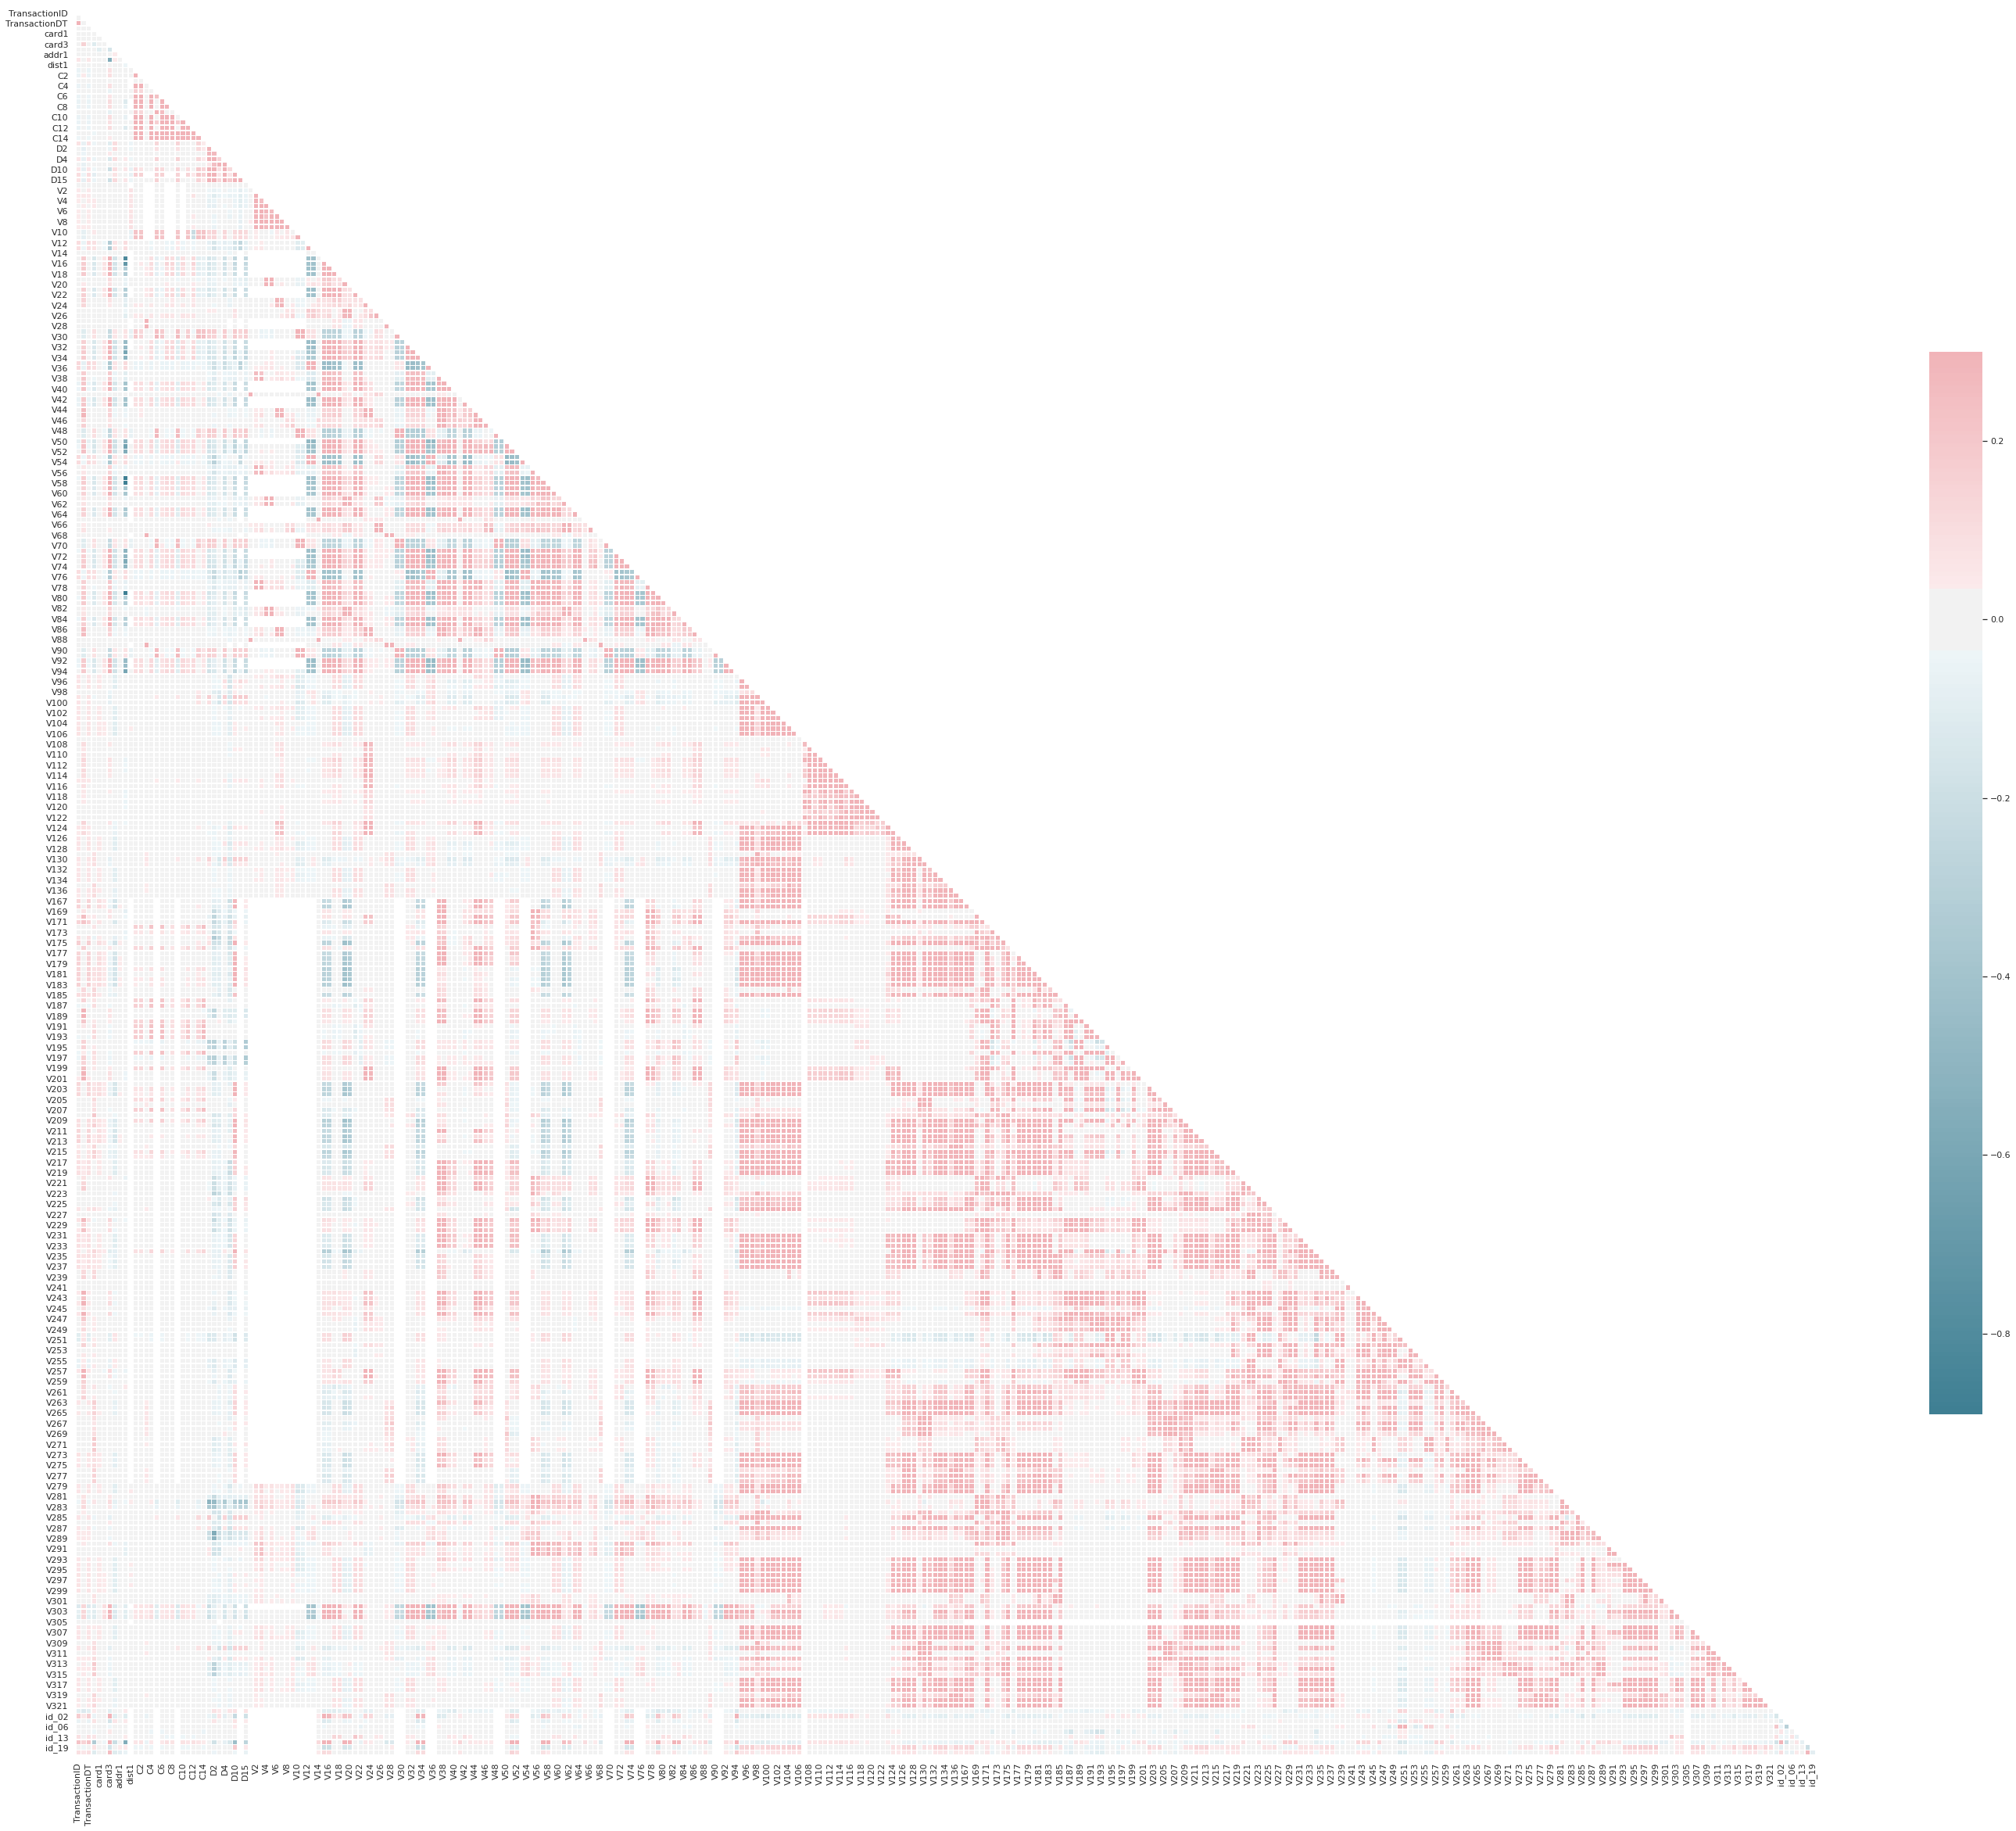

In [19]:
def sns_heatmap_diag(corr):
  """
  Plots diagonal correlation heatmap using Seaborn.  

  Parameters
  ----------
  corr : 2D numpy array    
      Correlation matrix from a pandas DF
      
  Returns
  -------
  None. Just plots the plot. 
  """
  # Set the plot style 
  sns.set(style="white")
  # Generate a mask for the upper triangle
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(50, 50))
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  try:
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  except ValueError:
    pass
  
  return None

sns_heatmap_diag(train.corr())

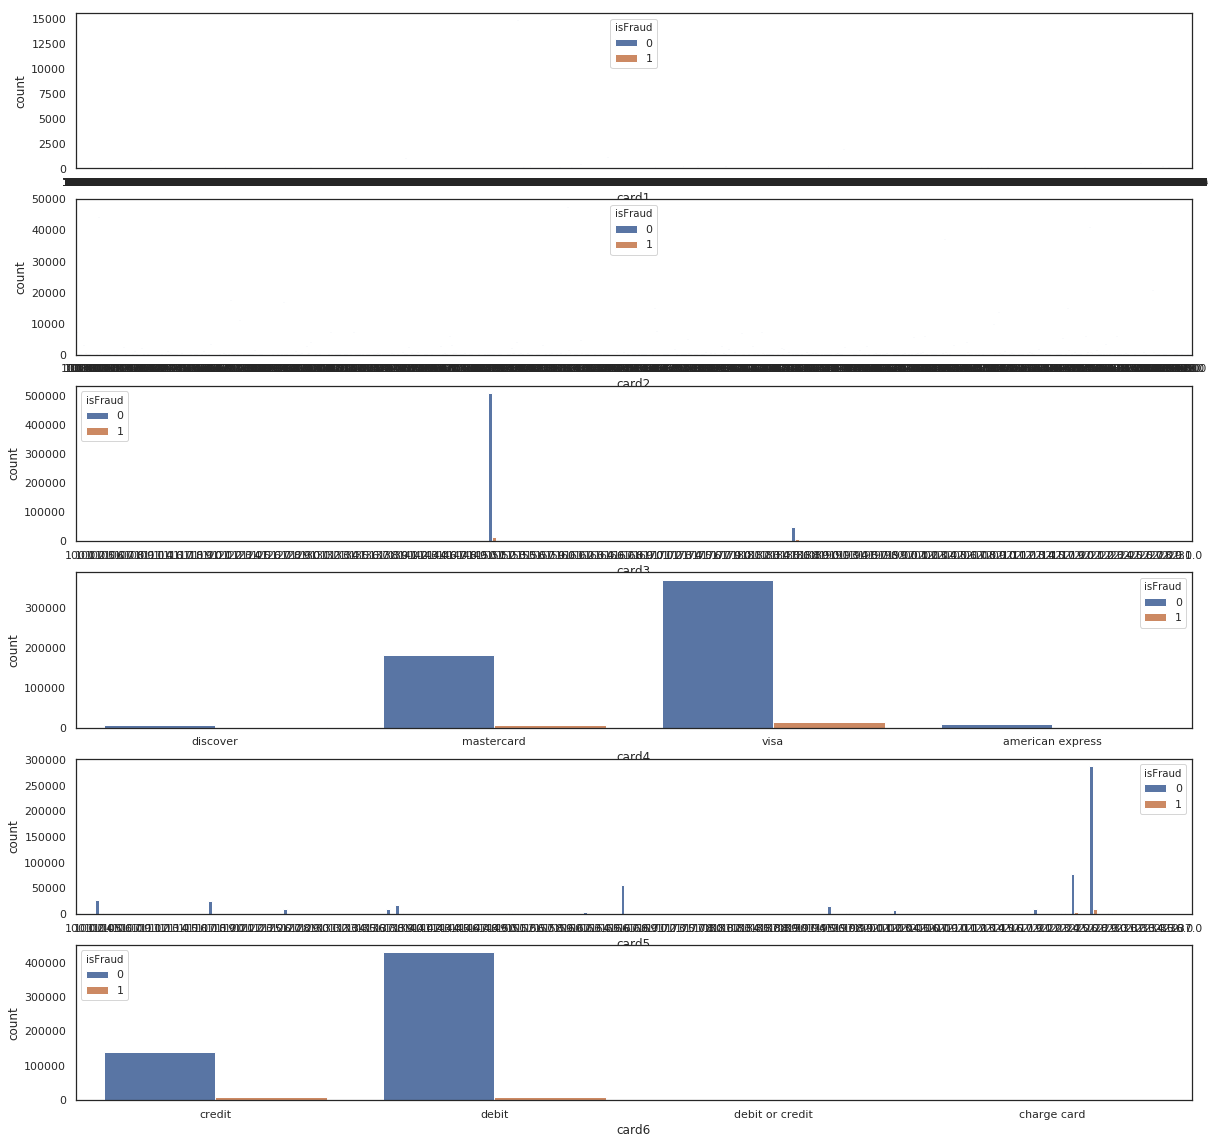

In [20]:
# Cards V Number of frauds and not frauds

fig, axs = plt.subplots(6,1, figsize=(20, 20), squeeze=False)

for i in range(1,7):
    sns.countplot(train['card'+str(i)], hue='isFraud', data=train, ax=axs[i-1][0])

In [21]:
# Lets us fill NA by type of column

# select types
object_cols = train.select_dtypes(include='object').columns
nobject_cols = train.select_dtypes(exclude='object').columns

print('Columns of Object Type\n{}'.format(object_cols.values))

Columns of Object Type
['ProductCD' 'card4' 'card6' 'P_emaildomain' 'R_emaildomain' 'M1' 'M2'
 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'id_12' 'id_15' 'id_16' 'id_28'
 'id_29' 'id_31' 'id_35' 'id_36' 'id_37' 'id_38' 'DeviceType' 'DeviceInfo']


In [22]:
train_copy = train.copy()

train[object_cols] = train[object_cols].fillna('NaN')
train[nobject_cols] = train[nobject_cols].fillna(0)

test[object_cols] = test[object_cols].fillna('NaN')
nobject_cols = list(nobject_cols)
nobject_cols.remove('isFraud')
test[nobject_cols] = test[nobject_cols].fillna(0)

In [23]:
train_y = train['isFraud']
train_X = train.drop('isFraud', axis=1)

In [25]:
# Label Encoding for categorical variables.

# LabelEncoding 
categorical_features = list(object_cols)

for col in categorical_features:
    le = preprocessing.LabelEncoder()
    le.fit(list(train_X[col].values) + list(test[col].values))
    train_X[col] = le.transform(list(train_X[col].values))
    test[col] = le.transform(list(test[col].values))

#for f in train_X.columns:
#    if train_X[f].dtype=='object' or test[f].dtype=='object': 
#        print(f)
#        lbl = preprocessing.LabelEncoder()
#        lbl.fit(list(train_X[f].values) + list(test[f].values))
#        train_X[f] = lbl.transform(list(train_X[f].values))
#        test[f] = lbl.transform(list(test[f].values))

In [26]:
train_X.head(5)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,4,13926,0.0,150.0,2,142.0,2,...,0.0,1,1,10,1,1,1,1,0,1317
1,2987001,86401,29.0,4,2755,404.0,150.0,3,102.0,2,...,0.0,1,1,10,1,1,1,1,0,1317
2,2987002,86469,59.0,4,4663,490.0,150.0,4,166.0,3,...,0.0,1,1,10,1,1,1,1,0,1317
3,2987003,86499,50.0,4,18132,567.0,150.0,3,117.0,3,...,0.0,1,1,10,1,1,1,1,0,1317
4,2987004,86506,50.0,1,4497,514.0,150.0,3,102.0,2,...,144.0,2,2,162,2,0,2,2,2,1566


In [27]:
logRegr = LogisticRegression(solver="liblinear")
logRegr.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(logRegr, train_X, train_y, cv=4, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.965, total=  41.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.0s remaining:    0.0s


[CV] .................................... , score=0.965, total=  28.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .................................... , score=0.965, total=  35.5s
[CV]  ................................................................
[CV] .................................... , score=0.956, total=  59.9s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min finished


0.9626934525088593

In [30]:
submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv',index_col='TransactionID')
submission.head()

,isFraud
TransactionID,
3663549,0.5
3663550,0.5
3663551,0.5
3663552,0.5
3663553,0.5


In [32]:
test_pred = logRegr.predict(test)

In [38]:
test_prob = logRegr.predict_proba(test)

In [50]:
submission=pd.DataFrame()
submission=test

submission['isFraud']=test_pred

submission.to_csv('submission1.csv')
#submission.head()